# Training the CNN model

In [1]:
import sys
sys.path.insert(1, '../src')
import app_constants as const
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Model
import keras
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D, Input
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam , SGD
from keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Recall
#Model Analysis
from sklearn.metrics import confusion_matrix

In [15]:
#provides easy way to transform images.
image_generator = ImageDataGenerator(validation_split=0.2)    

train_dataset = image_generator.flow_from_directory(
                                                 directory=const.DATA_DIR,
                                                 subset="training",
                                                 class_mode='categorical',
                                                 classes=const.LABELS,
                                                 shuffle=True,
                                                 seed=123,
                                                 target_size=(256, 256), 
                                                 batch_size=32,)

valid_dataset = image_generator.flow_from_directory(
                                                 directory=const.DATA_DIR,
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 classes=const.LABELS,
                                                 shuffle=True,
                                                 seed=123,
                                                 target_size=(256, 256), 
                                                 batch_size=32,)

# Multple frameworks:
# YOLO , CNNV2

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


# =============================================================================
# Model 1
# =============================================================================

In [3]:
# initializing the CNN
model = Sequential()
# Convolution layer-1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Convolution layer-2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Convolution layer-3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# flattening layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Output layer
model.add(Dense(const.NUM_CATEGORY, activation='softmax')) # because we have 3 classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0

In [16]:
# A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

# To avoid overfitting. Stop if no improvement in epochs
early_stopping = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          patience=100,
                          verbose = 1,
                          restore_best_weights = True)

# Save model after every epoch
model_check_point = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model1"),
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [early_stopping , model_check_point, learning_rate_reduction]

In [17]:
classifier = model.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks],
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 122s 5s/step - loss: 0.1757 - accuracy: 0.9429 - val_loss: 1.0014 - val_accuracy: 0.6938

Epoch 00001: val_accuracy improved from -inf to 0.69375, saving model to ../model/model1_temp.h5
Epoch 2/20
23/23 [==============================] - 124s 5s/step - loss: 0.2058 - accuracy: 0.9185 - val_loss: 0.4928 - val_accuracy: 0.8125

Epoch 00002: val_accuracy improved from 0.69375 to 0.81250, saving model to ../model/model1_temp.h5
Epoch 3/20
23/23 [==============================] - 122s 5s/step - loss: 0.2195 - accuracy: 0.9226 - val_loss: 0.5016 - val_accuracy: 0.8250

Epoch 00003: val_accuracy improved from 0.81250 to 0.82500, saving model to ../model/model1_temp.h5
Epoch 4/20
23/23 [==============================] - 118s 5s/step - loss: 0.1643 - accuracy: 0.9429 - val_loss: 0.6760 - val_accuracy: 0.7750

Epoch 00004: val_accuracy did not improve from 0.82500
Epoch 5/20
23/23 [==============================] - 118s 5s/step - loss: 0.2046 

In [18]:

y_pred_1 = model.predict(valid_dataset)

In [19]:
model.evaluate(valid_dataset)

95/95 [==============================] - 110s 1s/step - loss: 0.2955 - accuracy: 0.8980


[0.29549410939216614, 0.8980197906494141]

In [20]:
print(classifier.history["accuracy"])

[0.9429348111152649, 0.91847825050354, 0.9225543737411499, 0.9429348111152649, 0.9225543737411499, 0.9151846766471863, 0.9402173757553101, 0.9429348111152649, 0.9334239363670349, 0.917119562625885, 0.9415760636329651, 0.9384405016899109, 0.929347813129425, 0.94701087474823, 0.957880437374115, 0.94701087474823, 0.9442934989929199, 0.945652186870575, 0.938858687877655, 0.936141312122345]


In [22]:
model.save(const.get_model_path("model1"))

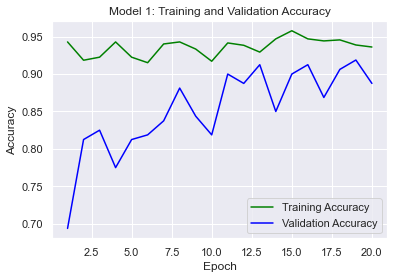

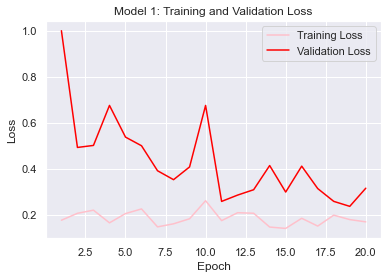

In [23]:
#plotting training values
sns.set()

acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Model 1: Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Model 1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

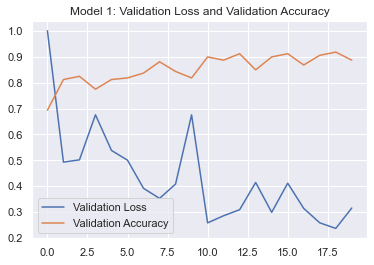

In [24]:
#train data accuracy and loss
plt.plot(classifier.history['val_loss'], label = 'Validation Loss')
plt.plot(classifier.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 1: Validation Loss and Validation Accuracy')
plt.legend()

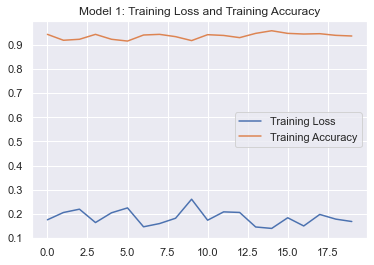

In [25]:
#test data accuracy and loss
plt.plot(classifier.history['loss'], label = 'Training Loss')
plt.plot(classifier.history['accuracy'], label = 'Training Accuracy')
plt.title('Model 1: Training Loss and Training Accuracy')
plt.legend()

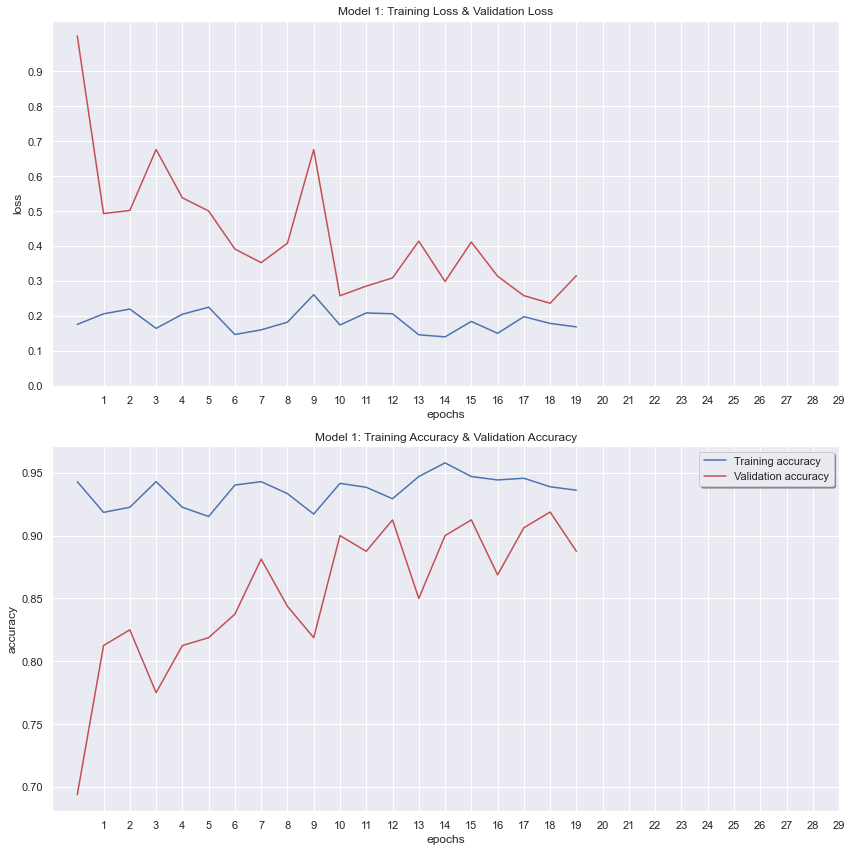

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier.history['loss'], color='b', label="Training loss")
ax1.plot(classifier.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Model 1: Training Loss & Validation Loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(classifier.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Model 1: Training Accuracy & Validation Accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

[[ 184  451   88]
 [ 558 1259  221]
 [  82  159   28]]


Text(0.5, 1.0, 'Model 1: Confusion Matrix')

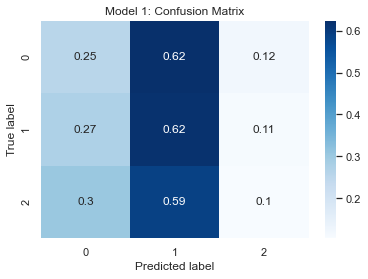

In [28]:

y_true = valid_dataset.classes
y_pred = np.argmax(y_pred_1, axis=1)
mat = confusion_matrix(
    y_true,
    y_pred)
print(mat)

conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Model 1: Confusion Matrix')

# =============================================================================
# Model 2
# =============================================================================


In [29]:
model_two = Sequential()
# Convolution layer-1
model_two.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer-2
model_two.add(Conv2D(64, (3, 3), activation='relu'))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer-3
model_two.add(Conv2D(128, (3, 3), activation='relu'))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer-4
model_two.add(Conv2D(256, (3, 3), activation='relu'))
model_two.add(MaxPooling2D(pool_size=(2, 2)))

# flattening layer
model_two.add(Flatten())
model_two.add(Dense(256, activation='relu'))

# Output layer
model_two.add(Dense(const.NUM_CATEGORY, activation='sigmoid'))

model_two.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)      

In [30]:
# To avoid overfitting. Stop if no improvement in epochs
early_stopping_2 = EarlyStopping(monitor = 'loss',
                          mode = 'min',
                          patience=10,
                          verbose = 1,
                          restore_best_weights = True)

# Save model after every epoch
model_check_point_2 = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model2"),
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction_2 = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.001)
callbacks_2 = [early_stopping_2 , model_check_point_2]

In [31]:
classifier2 = model_two.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_2],
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 85s 4s/step - loss: 68.5558 - accuracy: 0.4914 - val_loss: 0.4929 - val_accuracy: 0.7812

Epoch 00001: val_loss improved from inf to 0.49290, saving model to ../model/model2_temp.h5
Epoch 2/20
23/23 [==============================] - 82s 4s/step - loss: 0.6007 - accuracy: 0.7493 - val_loss: 0.7296 - val_accuracy: 0.6313

Epoch 00002: val_loss did not improve from 0.49290
Epoch 3/20
23/23 [==============================] - 73s 3s/step - loss: 0.5425 - accuracy: 0.7514 - val_loss: 0.5632 - val_accuracy: 0.7125

Epoch 00003: val_loss did not improve from 0.49290
Epoch 4/20
23/23 [==============================] - 80s 4s/step - loss: 0.4867 - accuracy: 0.7894 - val_loss: 0.5190 - val_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.49290
Epoch 5/20
23/23 [==============================] - 76s 3s/step - loss: 0.5041 - accuracy: 0.7823 - val_loss: 0.3924 - val_accuracy: 0.8062

Epoch 00005: val_loss improved from 0.49290 to 0.

In [32]:

y_pred2 = model_two.predict(valid_dataset)

In [33]:
model_two.evaluate(valid_dataset)

95/95 [==============================] - 89s 931ms/step - loss: 0.3106 - accuracy: 0.8733


[0.3106088638305664, 0.8732673525810242]

In [34]:
model_two.save(const.get_model_path("model2"))

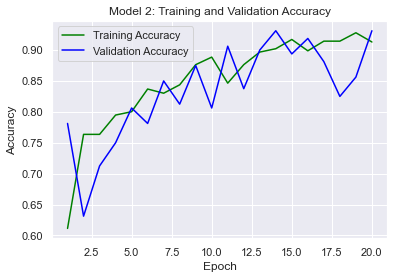

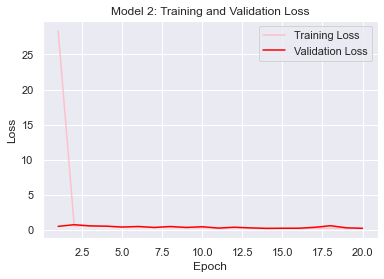

In [35]:
#plotting training values
sns.set()

acc = classifier2.history['accuracy']
val_acc = classifier2.history['val_accuracy']
loss = classifier2.history['loss']
val_loss = classifier2.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Model 2: Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Model 2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

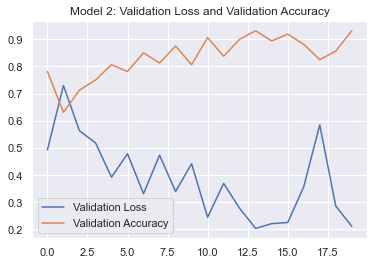

In [36]:
#train data accuracy and loss
plt.plot(classifier2.history['val_loss'], label = 'Validation Loss')
plt.plot(classifier2.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 2: Validation Loss and Validation Accuracy')
plt.legend()

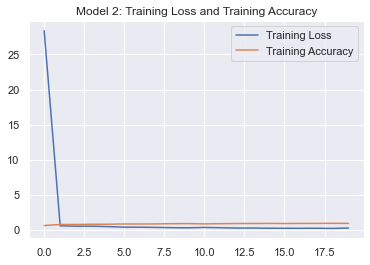

In [37]:
#test data accuracy and loss
plt.plot(classifier2.history['loss'], label = 'Training Loss')
plt.plot(classifier2.history['accuracy'], label = 'Training Accuracy')
plt.title('Model 2: Training Loss and Training Accuracy')
plt.legend()

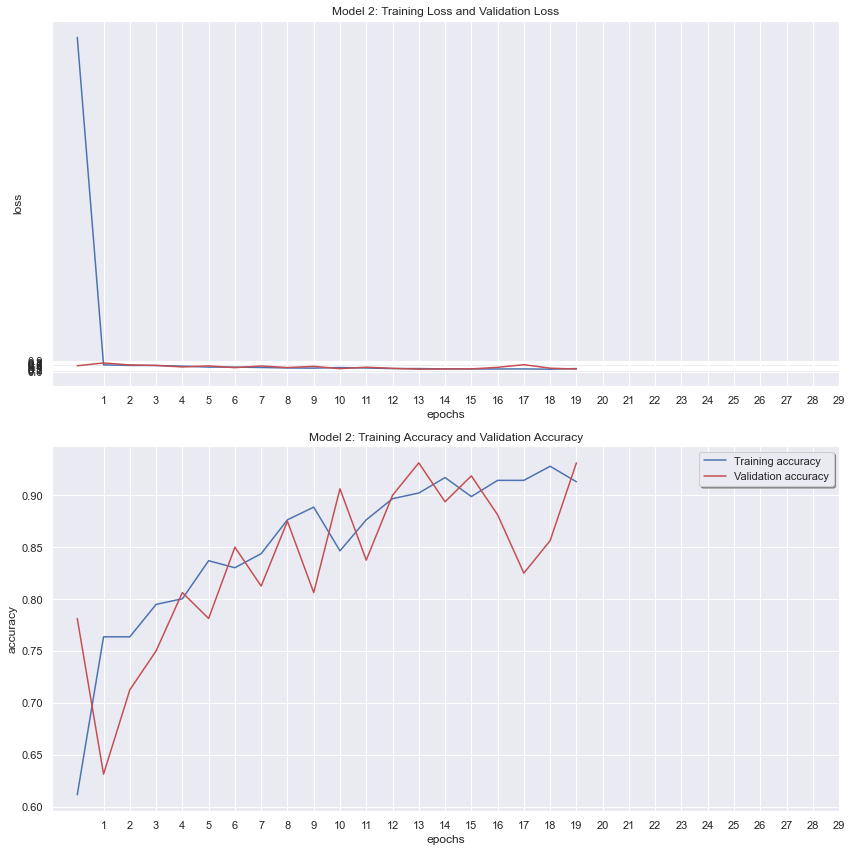

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier2.history['loss'], color='b', label="Training loss")
ax1.plot(classifier2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Model 2: Training Loss and Validation Loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(classifier2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Model 2: Training Accuracy and Validation Accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

[[ 108  527   88]
 [ 358 1445  235]
 [  48  193   28]]


Text(0.5, 12.5, 'Predicted label')

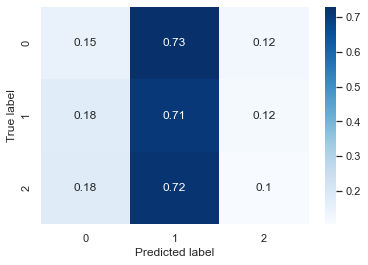

In [39]:

y_true = valid_dataset.classes
y_pred = np.argmax(y_pred2, axis=1)
mat = confusion_matrix(
    y_true,
    y_pred)
print(mat)

conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# =============================================================================
# Model 3
# =============================================================================

In [40]:
# Model 3
model_three = Sequential()

# Convolution layer-1
model_three.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256, 256, 3)))
model_three.add(BatchNormalization())

# Convolution layer-2
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model3.add(BatchNormalization())
model_three.add(MaxPooling2D(pool_size = (2, 2)))
model_three.add(Dropout(0.25))

# Convolution layer-3
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_three.add(BatchNormalization())

# Convolution layer-4
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model3.add(BatchNormalization())
model_three.add(AveragePooling2D(pool_size=(2, 2)))
model_three.add(Dropout(0.25))

# Convolution layer-5
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model3.add(BatchNormalization())
model_three.add(MaxPooling2D(pool_size = (2, 2)))
model_three.add(Dropout(0.25))

# Convolution layer-6
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_three.add(BatchNormalization())

# Convolution layer-7
model_three.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model_three.add(BatchNormalization())
model_three.add(AveragePooling2D(pool_size=(2, 2)))
model_three.add(Dropout(0.25))

# flattening layer
model_three.add(Flatten())
model_three.add(BatchNormalization())
model_three.add(Dense(128, activation='relu'))
model_three.add(Activation('relu'))
model_three.add(Dropout(0.25))

# Output layer
model_three.add(BatchNormalization())
model_three.add(Dense(const.NUM_CATEGORY, activation='softmax'))
model_three.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=[Recall()])
model_three.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 64)     

In [45]:
early_stopping_3 = EarlyStopping(monitor='val_loss',
                               mode = 'min',
                               patience=5,
                               verbose=1)

# Save model after every epoch
model_check_point_3 = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model3"),
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction_3 = ReduceLROnPlateau(monitor='val_recall', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks_3 = [early_stopping_3 , model_check_point_3, learning_rate_reduction_3]

In [46]:
classifier3 = model_three.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_3],
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 311s 13s/step - loss: 0.2691 - recall: 0.8913 - val_loss: 0.3375 - val_recall: 0.8750

Epoch 00001: val_loss improved from inf to 0.33753, saving model to ../model/model3_temp.h5
Epoch 2/20
23/23 [==============================] - 277s 12s/step - loss: 0.2844 - recall: 0.8845 - val_loss: 0.2669 - val_recall: 0.8750

Epoch 00002: val_loss improved from 0.33753 to 0.26689, saving model to ../model/model3_temp.h5
Epoch 3/20
23/23 [==============================] - 286s 12s/step - loss: 0.3043 - recall: 0.8709 - val_loss: 0.3033 - val_recall: 0.8687

Epoch 00003: val_loss did not improve from 0.26689
Epoch 4/20
23/23 [==============================] - 343s 15s/step - loss: 0.2921 - recall: 0.8899 - val_loss: 0.2870 - val_recall: 0.8813

Epoch 00004: val_loss did not improve from 0.26689
Epoch 5/20
23/23 [==============================] - 316s 14s/step - loss: 0.3060 - recall: 0.8764 - val_loss: 0.3038 - val_recall: 0.8938

Epoch 00005: va

In [47]:

y_pred3 = model_three.predict(valid_dataset)

In [48]:
model_three.evaluate(valid_dataset)

95/95 [==============================] - 279s 3s/step - loss: 0.3150 - recall: 0.8683


[0.3150482773780823, 0.8683168292045593]

In [52]:
print(classifier3.history )

{'loss': [0.2690902054309845, 0.2843564450740814, 0.30428346991539, 0.29213574528694153, 0.30600953102111816, 0.28922224044799805, 0.34867051243782043], 'recall': [0.8913043737411499, 0.88451087474823, 0.8709239363670349, 0.8899456262588501, 0.876358687877655, 0.866847813129425, 0.854619562625885], 'val_loss': [0.3375270366668701, 0.26688915491104126, 0.3033487796783447, 0.2870095670223236, 0.3038288950920105, 0.41778698563575745, 0.3203689455986023], 'val_recall': [0.875, 0.875, 0.8687499761581421, 0.8812500238418579, 0.893750011920929, 0.831250011920929, 0.831250011920929], 'lr': [0.0003125, 0.0003125, 0.0003125, 0.0003125, 0.0003125, 0.00015625, 0.00015625]}


In [53]:
model_three.save(const.get_model_path("model3"))

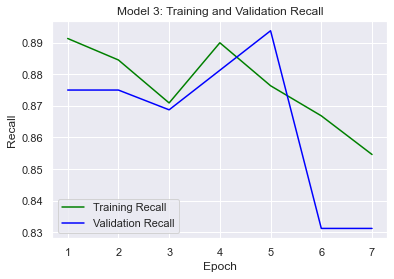

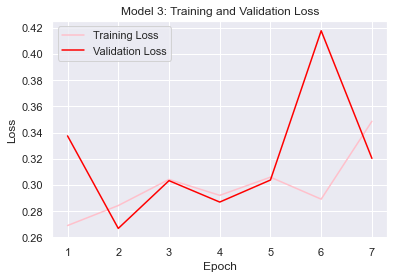

In [54]:
#plotting training values
sns.set()

rec = classifier3.history['recall']
val_rec = classifier3.history['val_recall']
loss = classifier3.history['loss']
val_loss = classifier3.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, rec, color='green', label='Training Recall')
plt.plot(epochs, val_rec, color='blue', label='Validation Recall')
plt.title('Model 3: Training and Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Model 3: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

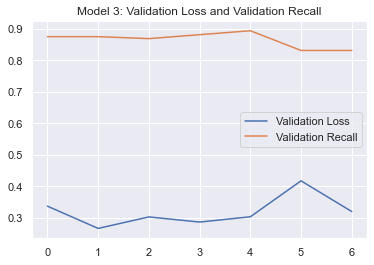

In [55]:
#train data accuracy and loss
plt.plot(classifier3.history['val_loss'], label = 'Validation Loss')
plt.plot(classifier3.history['val_recall'], label = 'Validation Recall')
plt.title('Model 3: Validation Loss and Validation Recall')
plt.legend()

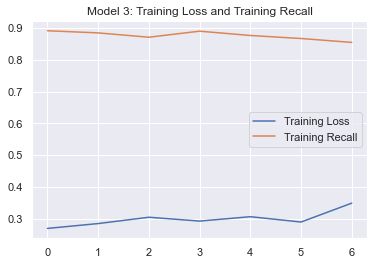

In [56]:
#test data accuracy and loss
plt.plot(classifier3.history['loss'], label = 'Training Loss')
plt.plot(classifier3.history['recall'], label = 'Training Recall')
plt.title('Model 3: Training Loss and Training Recall')
plt.legend()

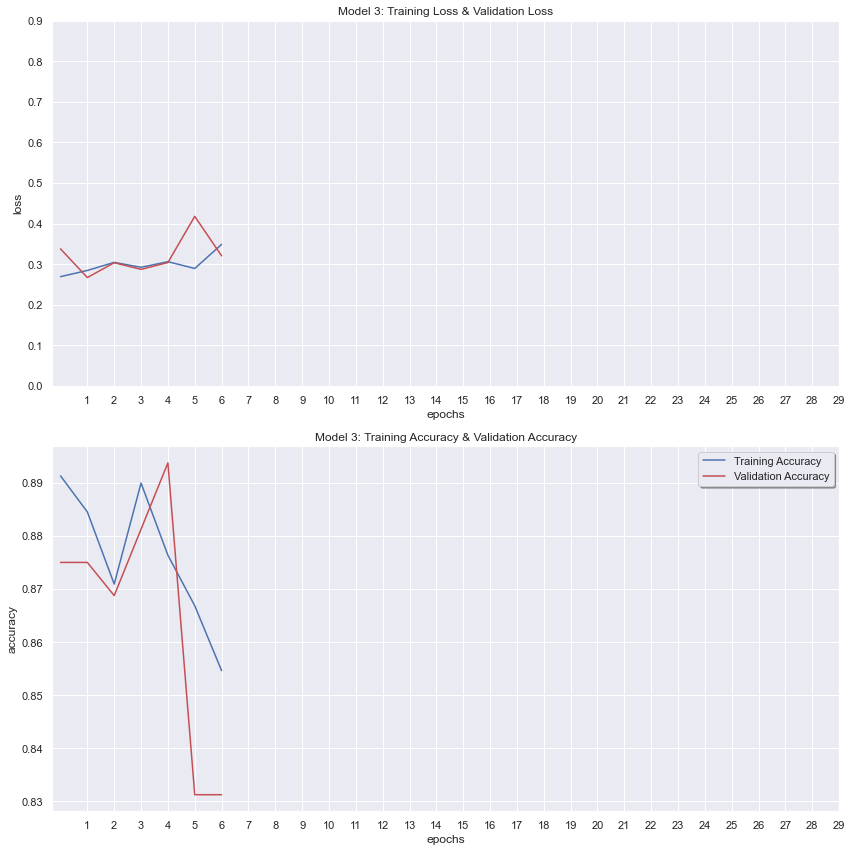

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier3.history['loss'], color='b', label="Training Loss")
ax1.plot(classifier3.history['val_loss'], color='r', label="validation Loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Model 3: Training Loss & Validation Loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier3.history['recall'], color='b', label="Training Accuracy")
ax2.plot(classifier3.history['val_recall'], color='r',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_title("Model 3: Training Accuracy & Validation Accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

[[ 178  456   89]
 [ 523 1266  249]
 [  59  174   36]]


Text(0.5, 12.5, 'Predicted label')

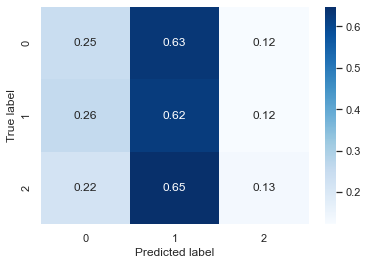

In [58]:

y_true = valid_dataset.classes
y_pred = np.argmax(y_pred3, axis=1)
mat = confusion_matrix(
    y_true,
    y_pred)
print(mat)

conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# =============================================================================
# Model 4
# =============================================================================


In [59]:
model_four = Sequential()
# Convolution layer-1
model_four.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(256, 256, 3)))
model_four.add(BatchNormalization())
model_four.add(Conv2D(32, (3, 3), activation='relu'))
model_four.add(MaxPooling2D(pool_size=(2, 2)))
# Convolution layer-2
model_four.add(Conv2D(64, (3, 3), activation='relu'))
model_four.add(MaxPooling2D(pool_size=(2, 2)))
model_four.add(Dropout(0.3))

# Convolution layer-3
model_four.add(Conv2D(128, (3, 3), activation='relu'))
model_four.add(MaxPooling2D(pool_size=(2, 2)))
model_four.add(Dropout(0.25))

# Convolution layer-4
model_four.add(Flatten())
model_four.add(Dense(256, activation='relu'))

# Output layer
model_four.add(Dropout(0.15))
model_four.add(Dense(const.NUM_CATEGORY, activation='softmax'))

model_four.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.005), metrics=['accuracy'])
model_four.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 62, 62, 64)       

In [60]:
early_stopping_4 = EarlyStopping(monitor='val_loss',
                               mode = 'auto',
                               patience=5,
                               verbose=1)

# Save model after every epoch
model_check_point_4 = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model4"),
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Reduce learning rate 
learning_rate_reduction_4 = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks_4 = [early_stopping_4 , model_check_point_4]

In [61]:
classifier_four = model_four.fit(train_dataset, 
                        validation_data = valid_dataset, 
                        batch_size = const.BATCH_SIZE, 
                        epochs = const.EPOCHS, 
                        callbacks = [callbacks_4],
                        steps_per_epoch = len(train_dataset) // const.BATCH_SIZE,
                        validation_steps = len(valid_dataset) // const.BATCH_SIZE,
                        verbose = 1)

Epoch 1/20
23/23 [==============================] - 164s 7s/step - loss: 1.2306 - accuracy: 0.6346 - val_loss: 0.6893 - val_accuracy: 0.7563

Epoch 00001: val_accuracy improved from -inf to 0.75625, saving model to ../model/model4_temp.h5
Epoch 2/20
23/23 [==============================] - 168s 7s/step - loss: 0.5639 - accuracy: 0.7181 - val_loss: 0.9082 - val_accuracy: 0.6500

Epoch 00002: val_accuracy did not improve from 0.75625
Epoch 3/20
23/23 [==============================] - 202s 9s/step - loss: 0.4942 - accuracy: 0.7785 - val_loss: 0.7363 - val_accuracy: 0.6812

Epoch 00003: val_accuracy did not improve from 0.75625
Epoch 4/20
23/23 [==============================] - 226s 10s/step - loss: 0.3988 - accuracy: 0.8173 - val_loss: 0.5269 - val_accuracy: 0.7937

Epoch 00004: val_accuracy improved from 0.75625 to 0.79375, saving model to ../model/model4_temp.h5
Epoch 5/20
23/23 [==============================] - 191s 8s/step - loss: 0.4472 - accuracy: 0.7941 - val_loss: 0.5551 - val_

In [62]:
y_pred4 = model_four.predict(valid_dataset)

In [63]:
model_four.evaluate(valid_dataset)

95/95 [==============================] - 227s 2s/step - loss: 0.3574 - accuracy: 0.8578


[0.3574179410934448, 0.8577557802200317]

In [64]:
model_four.save(const.get_model_path("model4"))

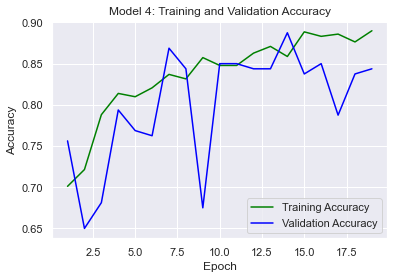

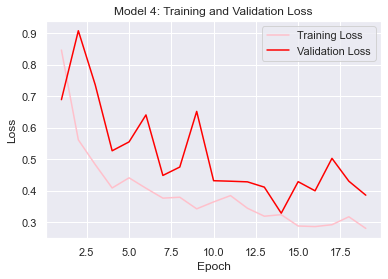

In [65]:
acc = classifier_four.history['accuracy']
val_acc = classifier_four.history['val_accuracy']
loss = classifier_four.history['loss']
val_loss = classifier_four.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Model 4: Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Model 4: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

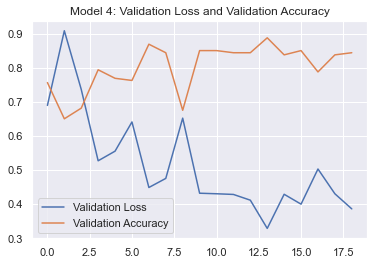

In [66]:
#train data accuracy and loss
plt.plot(classifier_four.history['val_loss'], label = 'Validation Loss')
plt.plot(classifier_four.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model 4: Validation Loss and Validation Accuracy')
plt.legend()


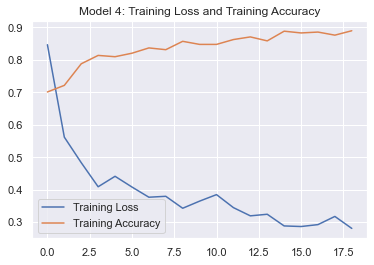

In [67]:
#test data accuracy and loss
plt.plot(classifier_four.history['loss'], label = 'Training Loss')
plt.plot(classifier_four.history['accuracy'], label = 'Training Accuracy')
plt.title('Model 4: Training Loss and Training Accuracy')
plt.legend()

In [68]:
y_true = valid_dataset.classes
y_pred = np.argmax(y_pred4, axis=1)
mat = confusion_matrix(
    y_true,
    y_pred)
print(mat)

[[ 199  471   53]
 [ 594 1292  152]
 [  93  161   15]]


Text(0.5, 12.5, 'Predicted label')

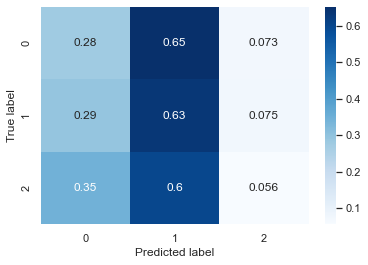

In [69]:
conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# =============================================================================
# VGG16 Model
# =============================================================================

https://www.kaggle.com/subhanjanbasu/dogs-cats-classifier-using-vgg16-and-densenet201

https://www.kaggle.com/abhaymudgal/dogs-vs-cats

https://keras.io/api/applications/vgg/

https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [70]:
base_conv = VGG16(weights='imagenet',
                 include_top=False,
                 input_tensor= Input(shape=(256,256, 3))
                )
base_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [71]:
base_conv.trainable = False

In [72]:
base_model = Sequential()
base_model.add(base_conv)

# Flatten layer
base_model.add(Flatten())
base_model.add(Dense(256, activation='relu'))

# Create new model on top.
inputs = Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
outputs = keras.layers.Dense(3)(x)
model_vgg = keras.Model(inputs, outputs)


model_vgg.compile(loss='categorical_crossentropy',
             optimizer = keras.optimizers.Adam(),
             metrics = ['acc'])
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 256)               23103552  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 771       
Total params: 23,104,323
Trainable params: 8,389,635
Non-trainable params: 14,714,688
_________________________________________________________________


In [73]:
early_stopping_vgg = EarlyStopping(monitor='val_acc',
                                 patience=5,
                                 verbose=1)
# Save model after every epoch
model_check_point_vgg = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model_vgg"),
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

callbacks_vgg = [early_stopping_vgg , model_check_point_vgg]

In [74]:
classifier_vgg = model_vgg.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_vgg],
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 471s 19s/step - loss: 2.4838 - acc: 0.1391 - val_loss: 0.2710 - val_acc: 0.0188

Epoch 00001: loss improved from inf to 1.41817, saving model to ../model/model_vgg_temp.h5
Epoch 2/20
23/23 [==============================] - 435s 19s/step - loss: 1.6904 - acc: 0.0133 - val_loss: 9.0452 - val_acc: 0.0000e+00

Epoch 00002: loss did not improve from 1.41817
Epoch 3/20
23/23 [==============================] - 461s 20s/step - loss: 12.0544 - acc: 0.0434 - val_loss: 11.2828 - val_acc: 0.2375

Epoch 00003: loss did not improve from 1.41817
Epoch 4/20
23/23 [==============================] - 413s 18s/step - loss: 11.7613 - acc: 0.2363 - val_loss: 11.6856 - val_acc: 0.2500

Epoch 00004: loss did not improve from 1.41817
Epoch 5/20
23/23 [==============================] - 423s 18s/step - loss: 11.6040 - acc: 0.2489 - val_loss: 12.1893 - val_acc: 0.2375

Epoch 00005: loss did not improve from 1.41817
Epoch 6/20
23/23 [============================

In [75]:

y_pred_vgg = model_vgg.predict(valid_dataset)

In [76]:
model_vgg.evaluate(valid_dataset)

95/95 [==============================] - 1385s 15s/step - loss: 11.8678 - acc: 0.2386


[11.867813110351562, 0.23861385881900787]

In [77]:
model_vgg.save(const.get_model_path("model_vgg"))

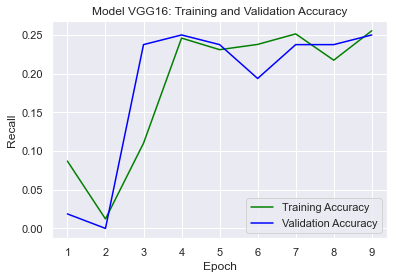

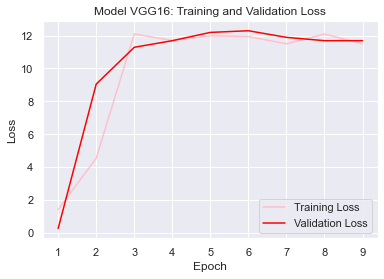

In [78]:
acc = classifier_vgg.history['acc']
val_acc = classifier_vgg.history['val_acc']
loss = classifier_vgg.history['loss']
val_loss = classifier_vgg.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Model VGG16: Training and Validation Accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Model VGG16: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

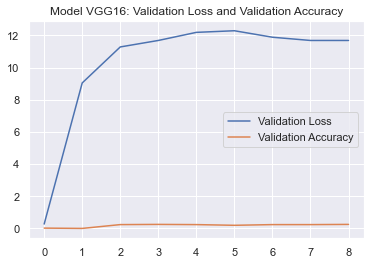

In [79]:
#train data accuracy and loss
plt.plot(classifier_vgg.history['val_loss'], label = 'Validation Loss')
plt.plot(classifier_vgg.history['val_acc'], label = 'Validation Accuracy')
plt.title('Model VGG16: Validation Loss and Validation Accuracy')
plt.legend()


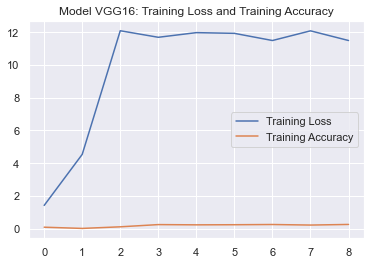

In [80]:
#test data accuracy and loss
plt.plot(classifier_vgg.history['loss'], label = 'Training Loss')
plt.plot(classifier_vgg.history['acc'], label = 'Training Accuracy')
plt.title('Model VGG16: Training Loss and Training Accuracy')
plt.legend()

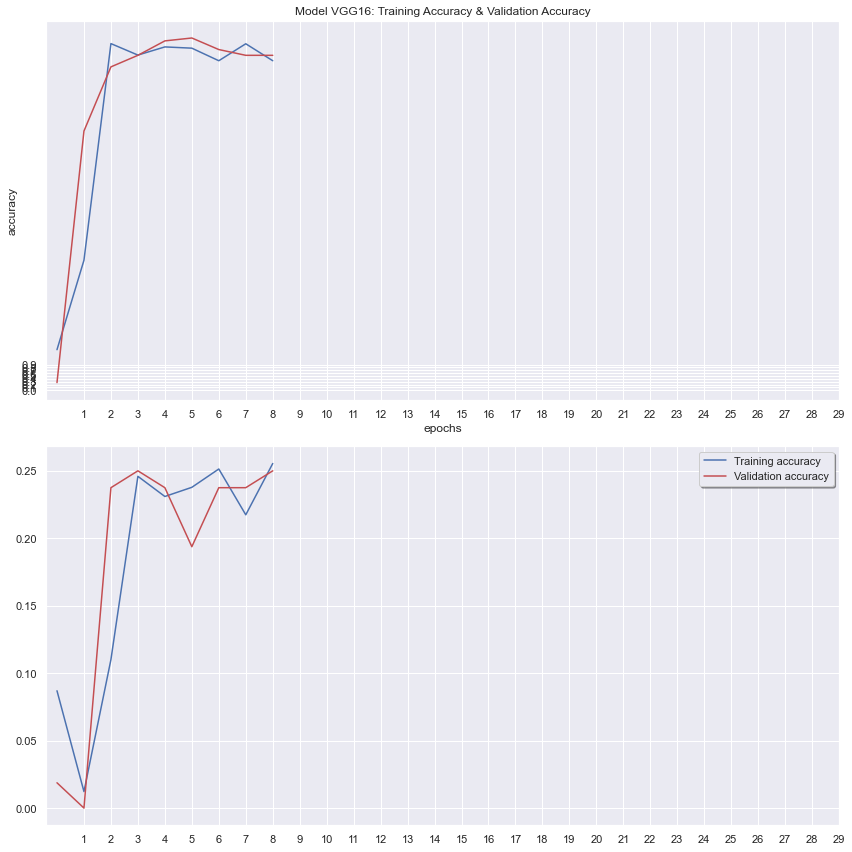

In [81]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier_vgg.history['loss'], color='b', label="Training loss")
ax1.plot(classifier_vgg.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Model VGG16: Training Loss & Validation Loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier_vgg.history['acc'], color='b', label="Training accuracy")
ax2.plot(classifier_vgg.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("Model VGG16: Training Accuracy & Validation Accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# =============================================================================
# ResNet 50
# =============================================================================

https://keras.io/api/applications/

In [82]:
base_resnet_conv = ResNet50(weights='imagenet',
                 include_top = False,
                 input_shape = (256,256, 3),
                 classes = const.NUM_CATEGORY
                )
base_resnet_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [83]:
base_resnet_conv.trainable = False

In [84]:
base_resnet_model = Sequential()
base_resnet_model.add(base_resnet_conv)

# Flatten layer
base_resnet_model.add(Flatten())
base_resnet_model.add(Dense(256, activation='relu'))

# Create new model on top.
inputs = Input(shape=(256, 256, 3))
x = base_resnet_model(inputs, training=False)
outputs = Dense(3)(x)
model_resnet = keras.Model(inputs, outputs)


model_resnet.compile(loss='categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])
model_resnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 256)               57142400  
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 57,143,171
Trainable params: 33,555,459
Non-trainable params: 23,587,712
_________________________________________________________________


In [85]:
early_stopping_resnet = EarlyStopping(monitor='acc',
                                 patience=2,
                                 verbose=1)
# Save model after every epoch
model_check_point_resnet = keras.callbacks.ModelCheckpoint(filepath=const.get_temp_model_path("model_resnet50"),
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

callbacks_resnet = [early_stopping_resnet , model_check_point_resnet]

In [ ]:
classifier_resnet = model_resnet.fit(train_dataset, 
                    steps_per_epoch=len(train_dataset) // const.BATCH_SIZE,
                    validation_steps=len(valid_dataset) // const.BATCH_SIZE,
                    validation_data=valid_dataset, 
                    epochs=const.EPOCHS,
                    callbacks=[callbacks_resnet],
                    verbose=1)

In [ ]:
y_pred_vgg = model_vgg.predict(valid_dataset)


In [ ]:
model_vgg.evaluate(valid_dataset)


In [ ]:
model_vgg.save(const.get_model_path("model_vgg"))